In [ ]:
# from __future__ import division

In [ ]:
%matplotlib qt5

In [1]:
# static inline plots:
%matplotlib inline
# interactive 3D plots:
#%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pylab
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread, imsave
from skimage import transform as tf
from sklearn import mixture
from sklearn import linear_model
import sys
import os
import numpy.matlib
pathname = '/home/pboord/flask/maxvp/app/static'
#img = cv2.imread(pathname+'/No.274, Section 2, Bade Road, Taipei, Taiwan.jpg')
img = cv2.imread(pathname+'/yelpHongKong4.jpg')
##img = cv2.imread(pathname+'/128-134 Camp Street.jpg')
##img = cv2.imread(pathname+'/121KweilinStreet.jpg')
#img = cv2.imread(pathname+'/21 Gough Street.jpg')
##img = cv2.imread(pathname+'/30 Pak Tin Street.jpg')
#img = cv2.imread(pathname+'/52-56 Pei Ho Street.jpg')
##img = cv2.imread(pathname+'/105 Argyle Street.jpg')
#img = cv2.imread(pathname+'/118-120 Fuk Wa Street.jpg')
##img = cv2.imread(pathname+'/140 Tai Po Road.jpg')
#img = cv2.imread(pathname+'/Address: 2F, No. 128 Songjiang Road, Zhongshan District, Taipei 104, Taiwan.jpg')
##img = cv2.imread(pathname+'/Lai Chi Kok Road.jpg')
##img = cv2.imread(pathname+'/No.50 Section 1, Nanchang Road, Zhongzheng District, Taipei, Taiwan.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H, W = img.shape[:2]
def imshow(img):
    cv2.imshow('image', img)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
def add_lines_to_image(img, lines):
    for i in range(0,lines.shape[0]):
        cv2.line(img,(lines[i][0],lines[i][1]), (lines[i][2],lines[i][3]),(0,0,255),3,8 )
    return im
def line_scatter(lines, **kwargs):
    if len(a) == 0:
        # slope displayed in 2D
        m2d = np.absolute(np.column_stack((lines[:,2] - lines[:,0], lines[:,3] - lines[:,1])))
        fig, ax = plt.subplots()
        ax.scatter(m2d[:,0],m2d[:,1])
    else:
        fig.suptitle(kwargs['title'], fontsize=20, y = 1.08)
        ax.set_xlabel(kwargs['xlabel'], fontsize=20)
        ax.set_ylabel(kwargs['ylabel'], fontsize=20)
def img_to_canny(img):
    # Canny
    # http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html
    thrs1 = 50
    thrs2 = 200
    canny = cv2.Canny(img, thrs1, thrs2, apertureSize=3)
    return canny
def canny_to_lines(canny):
    #cv2.imshow('Canny', canny)
    #cv2.imwrite(pathname+'/Canny.jpg',canny)
    # http://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp
    lines = cv2.HoughLinesP(canny,1, np.pi/180, 80, 30, 10)[:,0,:]
    return lines
def line_to_angle(lines):
    # lines: (N, 4) ndarray of N x 4-element vector  (x_1, y_1, x_2, y_2) , where  (x_1,y_1) and  (x_2, y_2) are the ending points of each line
    #angles = np.arctan2(lines[:,3] - lines[:,1], lines[:,2] - lines[:,0]) * 180 / np.pi
    angles = np.arctan(np.true_divide(lines[:,3] - lines[:,1], lines[:,2] - lines[:,0]))
    return angles
def angle_to_gmm(angles):
    gmm = mixture.GaussianMixture(n_components=2, covariance_type='spherical').fit(np.absolute(m))
    classMost = gmm.predict(np.absolute(m))==0
def angle_to_gmm3(angles):
    cos_sin_angle = np.c_[np.cos(2 * angles),np.sin(2 * angles)]
    #gmm = mixture.GaussianMixture(n_components=3, covariance_type='spherical').fit(cos_sin_angle)
    gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag').fit(cos_sin_angle)
    class_predict = gmm.predict(cos_sin_angle)
    return class_predict
def principal_edges(angles, class_predict):
    nr_class = np.max(class_predict) + 1
    class_angles = np.zeros((nr_class,))
    for c in range(0,nr_class):
        class_c_angles = angles[class_predict==c]
        class_c_mean_angle = np.angle(np.sum(np.exp(1j*class_c_angles)))
        class_angles[c] = class_c_mean_angle
    # select class closest to vanishing point horizon
    principal_class = class_predict == np.argmin(np.abs(class_angles))
    return principal_class
def robust_regressor(height, angles, principal_class):
    principal_indices = np.nonzero(principal_class)
    height = height[principal_class]
    angles = angles[principal_class]
    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(np.c_[height,np.ones((height.shape[0],))], angles)
    inlier_mask = model_ransac.inlier_mask_
    principal_class.flat[np.nonzero(principal_class)] = inlier_mask
    return principal_class, model_ransac
def warp_img(img, top_btm_angle):
    H, W = img.shape[:2]
    top_right_add = int(W * np.tan(top_btm_angle[0]) / 2)
    btm_right_add = int(W * np.tan(top_btm_angle[1]) / 2)
    src = np.array([[0, 0], [0, H], [W, H], [W, 0]])
    dst = np.array([[0, -top_right_add], [0, H - btm_right_add], [W, H + btm_right_add], [W, top_right_add]])
    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    warped_img = tf.warp(img, tform3, output_shape=img.shape)
    return warped_img
H, W

(1000, 1000)

In [2]:
canny = img_to_canny(gray)
lines = canny_to_lines(canny)
angles = line_to_angle(lines)
class_predict = angle_to_gmm3(angles)
principal_class = principal_edges(angles, class_predict)
lines_x = lines[:,[0,2]]
lines_y = lines[:,[1,3]]
height = np.average(lines_y,axis=1)
principal_inlier_class, model_ransac = robust_regressor(height, angles, principal_class)
top_btm_angle = model_ransac.predict(np.c_[[0,H], [1,1]])
warped_img = warp_img(img, top_btm_angle)


imsave(pathname+'/warped.jpg',warped_img)
cv2.imshow('warped',warped_img)
cv2.waitKey(0) 
cv2.destroyAllWindows()

/home/pboord/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: divide by zero encountered in true_divide
/home/pboord/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [ ]:
warped_im.shape

In [ ]:
img.shape

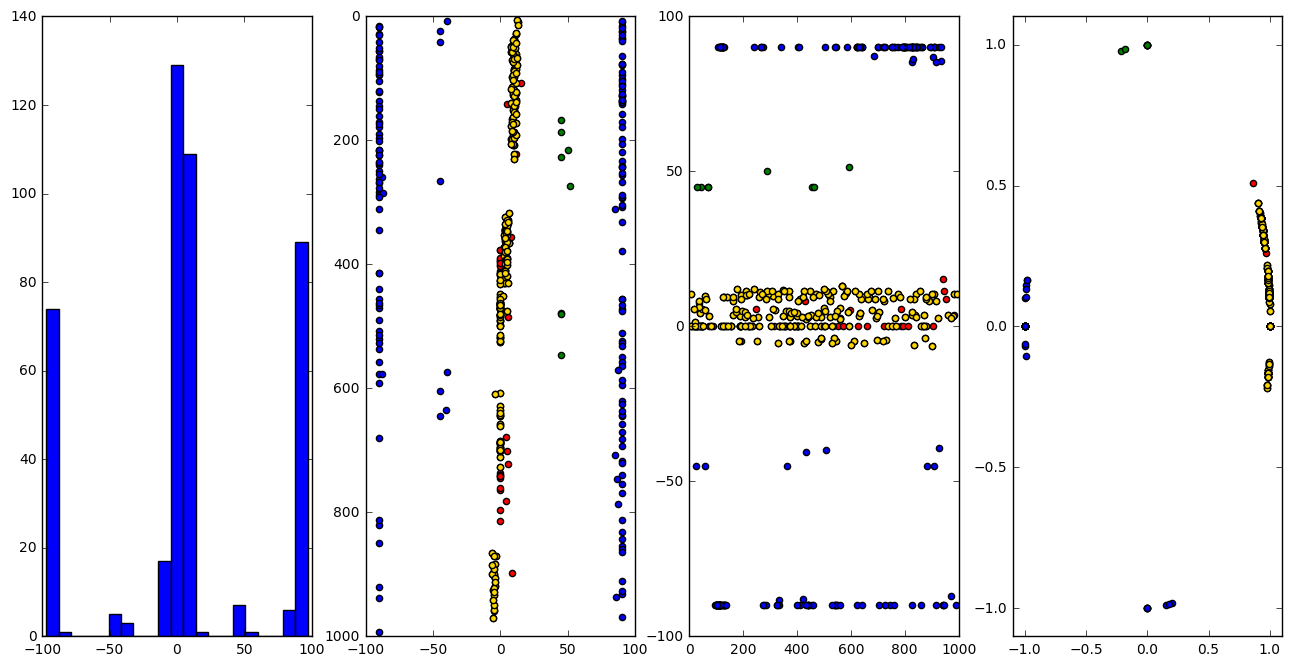

In [4]:
fig, ax = plt.subplots(nrows=1, ncols = 4, figsize=(16, 8))
ax[0].hist(angles * 180 / np.pi, bins=np.linspace(-180,180,40))
ax[0].set_xlim(left = -100, right = 100)
ax[1].scatter(angles[class_predict==0] * 180 / np.pi,np.average(lines_y[class_predict==0,:],axis=1),c='b')
ax[1].scatter(angles[class_predict==1] * 180 / np.pi,np.average(lines_y[class_predict==1,:],axis=1),c='r')
ax[1].scatter(angles[class_predict==2] * 180 / np.pi,np.average(lines_y[class_predict==2,:],axis=1),c='g')
ax[1].scatter(angles[principal_inlier_class] * 180 / np.pi,np.average(lines_y[principal_inlier_class,:],axis=1),c='gold')
ax[1].set_ylim(bottom = H, top = 0)
ax[1].set_xlim(left = -100, right = 100)
ax[2].scatter(np.average(lines_x[class_predict==0,:],axis=1),angles[class_predict==0] * 180 / np.pi,c='b')
ax[2].scatter(np.average(lines_x[class_predict==1,:],axis=1),angles[class_predict==1] * 180 / np.pi,c='r')
ax[2].scatter(np.average(lines_x[class_predict==2,:],axis=1),angles[class_predict==2] * 180 / np.pi,c='g')
ax[2].scatter(np.average(lines_x[principal_inlier_class,:],axis=1),angles[principal_inlier_class] * 180 / np.pi,c='gold')
ax[2].set_ylim(bottom = -100, top = 100)
ax[2].set_xlim(left = 0, right = W)
ax[3].scatter(np.cos(2 * angles[class_predict==0]),np.sin(2 * angles[class_predict==0]),c='b')
ax[3].scatter(np.cos(2 * angles[class_predict==1]),np.sin(2 * angles[class_predict==1]),c='r')
ax[3].scatter(np.cos(2 * angles[class_predict==2]),np.sin(2 * angles[class_predict==2]),c='g')
ax[3].scatter(np.cos(2 * angles[principal_inlier_class]),np.sin(2 * angles[principal_inlier_class]),c='gold')
ax[3].set_xlim(left = -1.1, right = 1.1)
ax[3].set_ylim(bottom = -1.1, top = 1.1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.average(lines_x[principal_inlier_class,:],axis=1), np.average(lines_y[principal_inlier_class,:],axis=1), angles[principal_inlier_class] * 180 / np.pi, zdir='z', c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
# attempt using Sobel derivates did not work...
# ksize = 3
# # dx = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize)
# # dy = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize)
# dx = cv2.Scharr(gray, cv2.CV_16S, 1, 0)
# dy = cv2.Scharr(gray, cv2.CV_16S, 0, 1)
# with np.errstate(divide='ignore', invalid='ignore'):
#     m = np.true_divide(dy,dx)
# m[ dx == 0 ] = 0
# # # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# # k = 0.04
# # eig = cv2.cornerEigenValsAndVecs(gray, 5, 3)
# # eigVal0 = eig[:,:,0]
# # eigVal1 = eig[:,:,1]
# # R = np.multiply(eigVal0,eigVal1) - k*(eigVal0 + eigVal1)**2
# # isEdge = R < 0

# # # discard non-edges
# # m[np.logical_not(isEdge)] = 0
# # cv2.imshow('posSlope', np.multiply(m, m > 0))
# # cv2.imshow('negSlope', -1*np.multiply(m, m < 0))
# # cv2.waitKey(0) 
# # cv2.destroyAllWindows()

# hwIdx = np.unravel_index(range(0,H*W),(H, W))
# hIdx = hwIdx[0]
# wIdx = hwIdx[1]
# m = np.reshape(m,[-1,])


# #isEdge = np.reshape(isEdge,[-1,])


# # # bl2tr = -
# # # limit slope values
# # m_thresh = 0.5*h/w
# # selectEdge = np.logical_and(isEdge, np.absolute(m) < m_thresh)
# # # only consider selected edges
# # hIdx = hIdx[selectEdge]
# # wIdx = wIdx[selectEdge]
# # m = m[selectEdge]
# # a = np.column_stack( ( np.ones((m.shape[0],)), m ) )
# # b = hIdx - m*wIdx
# # x = np.linalg.lstsq(a,b)
# # x

# # bl2tr = +
# # limit slope values
# m_thresh = 0.8*H/W
# #canny =np.reshape(canny,[-1,])
# #selectEdge = np.logical_and(np.logical_and(isEdge, np.absolute(m) < m_thresh), canny > 0)

# selectEdge = m != 0
# #selectEdge = isEdge

# # only consider selected edges
# hIdx = hIdx[selectEdge]
# wIdx = wIdx[selectEdge]
# m = m[selectEdge]
# # Solve Ax = B
# A = np.column_stack( ( np.ones((m.shape[0],)), -m ) )
# B = hIdx + m*wIdx
# x = np.linalg.lstsq(A, B)
# g = x[0][0]
# # Why x[0][1] is negative?!?
# # And why is Sobel output negated?? ... related?
# d = x[0][1]
# a = g - d*g/(d + W)
# b = d*(H - g)/(d + W) + g
# a,b,g,d

In [ ]:
# unused stuff
#
# k = 0.04
# eig = cv2.cornerEigenValsAndVecs(gray, 5, 3)
# eigVal0 = eig[:,:,0]
# eigVal1 = eig[:,:,1]
# x0 = eig[:,:,2]
# y0 = eig[:,:,3]
# x1 = eig[:,:,4]
# y1 = eig[:,:,5]
# # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# R = np.multiply(eigVal0,eigVal1) - k*(eigVal0 + eigVal1)**2
# isEdge = R < 0
# with np.errstate(divide='ignore', invalid='ignore'):
#     m0 = np.true_divide(y0,x0)
# m0[ x0 == 0 ] = 0
# with np.errstate(divide='ignore', invalid='ignore'):
#     m1 = np.true_divide(y1,x1)
# m1[ x1 == 0 ] = 0
# m = np.multiply(eigVal0 > eigVal1, m0) + np.multiply(eigVal1 > eigVal0, m1)
# hwIdx = np.unravel_index(range(0,h*w),(h,w))
# hIdx = hwIdx[0]
# wIdx = hwIdx[1]
# m = np.reshape(m,[-1,])
# isEdge = np.reshape(isEdge,[-1,])
# # only consider edges
# hIdx = hIdx[isEdge]
# wIdx = wIdx[isEdge]
# m = m[isEdge]


# # edgeSlopes = np.multiply(isEdge,m)
# # posSlopeEdge = np.multiply(edgeSlopes, edgeSlopes > 0)
# # negSlopeEdge = np.multiply(edgeSlopes, edgeSlopes < 0)
# # cv2.imshow('posSlope', posSlopeEdge)
# # cv2.imshow('negSlope', -1*negSlopeEdge)
# # cv2.waitKey(0) 
# # cv2.destroyAllWindows()


In [ ]:
# m1d = np.absolute(np.true_divide(lines[:,3] - lines[:,1], lines[:,2] - lines[:,0])).T
# plt.hist(m1d, bins=np.linspace(0,2,10))
# plt.show()

In [ ]:
# import sklearn
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [ ]:
# cv2.CV_PI = 3.1415926535897932384626433832795
# thrs1 = 50
# thrs2 = 200
# canny = cv2.Canny(gray, thrs1, thrs2, apertureSize=3)
# #lines = cv2.HoughLinesP(canny,1, cv2.CV_PI/180, 80, 30, 10)[:,0,:]
# # args: image, rho, theta, threshold, lines, minLineLength, maxLineGap
# rho = 1
# theta = cv2.CV_PI/180
# threshold = 200
# min_line_len = 100
# max_line_gap = 100
# lines = cv2.HoughLinesP(canny, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)[:,0,:]
# color_dst = cv2.cvtColor(canny,cv2.COLOR_GRAY2BGR)
# for i in range(0,lines.shape[0]):
#     cv2.line(color_dst,(lines[i][0],lines[i][1]), (lines[i][2],lines[i][3]),(0,0,255),3,8 )
# print lines.shape
# imshow(color_dst)

In [ ]:
# top_right_add = int(W * np.tan(top_btm_angle[0]) / 2)
# btm_right_add = int(W * np.tan(top_btm_angle[1]) / 2)
# top_right_add, btm_right_add
# src = np.array([[0, 0], [0, H], [W, H], [W, 0]])
# dst = np.array([[0, -top_right_add], [0, H - btm_right_add], [W, H + btm_right_add], [W, top_right_add]])

# principal_indices = np.nonzero(principal_class)
# height = height[principal_class]
# angles = angles[principal_class]
# # Robustly fit linear model with RANSAC algorithm
# model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
# model_ransac.fit(np.c_[height,np.ones((height.shape[0],))], angles)
# model_ransac.predict(np.c_[[0,H], [1,1]]) * 180/np.pi

# import math
# import matplotlib.pyplot as plt

# from skimage.io import imread, imsave
# from skimage import transform as tf

# src = np.array([[0, 0], [0, H], [W, H], [W, 0]])
# dst = np.array([[0, -top_right_add], [0, H - btm_right_add], [W, H + btm_right_add], [W, top_right_add]])
# #dst = np.array([[0, b], [0, a], [W, H], [W, 0]])

# tform3 = tf.ProjectiveTransform()
# tform3.estimate(src, dst)
# warped = tf.warp(img, tform3, output_shape=img.shape)
# imsave(pathname+'/warped.jpg',warped)
# cv2.imshow('warped',warped)

# fig, figAx = plt.subplots(nrows=2, figsize=(8, 3))

# figAx[0].imshow(gray, cmap=plt.cm.gray)
# figAx[0].plot(dst[:, 0], dst[:, 1], '.r')
# #figAx[1].imshow(warped, cmap=plt.cm.gray)
# figAx[1].imshow(warped)

# for ax in figAx:
#     ax.axis('off')
    
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

In [ ]:
# # with Vert
# color_dst = cv2.cvtColor(canny,cv2.COLOR_GRAY2BGR)
# color_dst = add_lines_to_image(color_dst, lines)
# fig, figAx = plt.subplots(nrows=1, ncols = 2, figsize=(16, 8))
# figAx[0].imshow(img)
# figAx[1].imshow(color_dst)
# for ax in figAx:
#     ax.axis('off')
# cv2.imshow('withVert', color_dst)
# cv2.imwrite(pathname+'/withVert.jpg',color_dst)
# # without Vert
# # delete vertical lines (avoids divide by zero)
# lines = lines[lines[:,0] != lines[:,2],:]
# m = np.true_divide(lines[:,3] - lines[:,1],lines[:,2] - lines[:,0])
# # # delete line with max abs slope > 2 (45 degrees)
# # lines = lines[np.absolute(m) < 2,:]
# # m = m[np.absolute(m) < 2]
# # # keep lines only from largest subset
# # m = m[:,np.newaxis]
# # from sklearn import mixture
# # gmm = mixture.GaussianMixture(n_components=2, covariance_type='spherical').fit(np.absolute(m))
# # classMost = gmm.predict(np.absolute(m))==0
# # if np.sum(classMost) < m.shape[0]/2:
# #     classMost = np.logical_not(classMost)
# # lines = lines[classMost,:]
# # m = m[classMost]
# # m = m[:,0]

# color_dst = cv2.cvtColor(canny,cv2.COLOR_GRAY2BGR)
# for i in range(0,lines.shape[0]):
#     cv2.line(color_dst,(lines[i][0],lines[i][1]), (lines[i][2],lines[i][3]),(0,0,255),3,8 )
# cv2.imshow('withoutVert', color_dst)
# cv2.imwrite(pathname+'/withoutVert.jpg',color_dst)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# # delete horizontal lines (they don't have info to estimate vp & avoids div by zero)
# lines = lines[m != 0,:]
# m = m[m != 0]
# import numpy.matlib
# A = np.column_stack( ( np.ones((m.shape[0],)), -m ) )
# B = lines[:,1] - m*lines[:,0]
# # # reduce LSE sensitivity to large slopes
# # # weighted least squares(?)
# # A=np.true_divide(A, np.matlib.repmat(np.absolute(m)[:,np.newaxis],1,2))
# # B=np.true_divide(B, np.absolute(m))
# # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
# x = np.linalg.lstsq(A, B)
# g = x[0][0]
# d = x[0][1]
# #d = 3 * x[0][1]
# g,d
# #x

# a = g + np.true_divide(d*g,(W - d))
# b = g + np.true_divide(d*(g - H), (W - d))
# # a = g + d*g/(W - d)
# # b = g + d*(g - H)/(W - d)
# g, d, a, b